# Classifying Statement Sentiments using Neural Networks  
### Final Coursework for Machine Learning and Neural Networks

## The Problem

For this application I will be using a custom dataset that I selected. The data is in the form of a CSV file with two columns. Column one contains a list of statements, followed by labels in the second column about what the emotion / sentiment of the statement is, like sadness, anger, happy, etc. The problem is to perform text classification on this dataset. Specifically, I want to categorise each a sentence into one of the predefined sentiments. So, the goal for this paper is to build a model that can accurately classify the sentiment of each of the statements.

**Key points:**
- **Input Data** - Dataset in text form of statements, and a corisponding sentiment label
- **Type of Problem** - Multi-class text classification
- **Prediction Objective** - Predict the the sentiment of a statement


In [19]:
import pandas as pd

# Data downloaded from Kaggle and the link below
# https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text?resource=download
data = pd.read_csv("Emotion_final.csv")
# Extract content and sentiment columns
statements = data["content"]
sentiments = data["sentiment"]

unique_sentiments = sentiments.unique()
print("A total of", len(unique_sentiments), "possible sentiments, which are:", unique_sentiments, end="\n\n")

print("A sample from the data:")
print("Index\tSentiment\tStatement\n" + "-" * 35)
for i in range(0, 5):
    print(i, sentiments[i] + "\t", statements[i], sep="\t")

A total of 6 possible sentiments, which are: ['sadness' 'anger' 'love' 'surprise' 'fear' 'happy']

A sample from the data:
Index	Sentiment	Statement
-----------------------------------
0	sadness		i didnt feel humiliated
1	sadness		i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
2	anger		im grabbing a minute to post i feel greedy wrong
3	love		i am ever feeling nostalgic about the fireplace i will know that it is still on the property
4	anger		i am feeling grouchy


## Measure of Success

The primary measure of success for this Multi-class text classification problem will be the classification accuracy on the test set. The accuracy represents the percentage of correctly classified statements in the test data. A high level of accuracy will indicate that the model can accurately classify the sentiment of a statement, completing the goal stated earlier.

To provide context to the accuracy, a baseline accuracy is also calculated. The very simplest method would involve picking a random label, resulting in a 16.67% (1/6) chance of being correct. This value is quite low, and we can do better than that, even without using a complex model. So instead the model implemented will need to beat a slightly more complex baseline. It will work by selecting the sentiment class that appears most often, and then use that label as the predicted label for all statements in the test set. This method serves as an educated guess, rather than randomly selecting a label. The baseline accuracy that is calculated will serve as a reference point for evaluating the model's performance.

## Evaluation Protocol

The evaluation protocol employed in this project is a hold-out validation split. The dataset is divided into three main subsets. Specifically, 80% of the data is used for training, 10% for validation during the model's training to monitor the model's performance, and the remaining 10% for final testing, which represents unseen data that the model has not encountered during training or validation.

**Reason for Hold-Out Validation:**
- **Simplicity** - It is a straightforward and easy-to-implement method for assessing model performance.
- **Dataset Size** - From testing, the dataset appears to be sufficiently large to allow for an effective hold-out split without the model losing valuable information because of the split.
- **Efficiency** - Hold-out validation is computationally efficient, due to its simplicity, making it ideal for a small project like this.


## Preparing the Data

In [20]:
import tensorflow as tf
from tensorflow import keras

Create a dictionary mapping sentiment labels to numerical values, before encoding all of the the sentiments in the input data.

In [21]:
target = {key: index for index, key in enumerate(sentiments.unique())}
encoded_sentiments = sentiments.map(target)

**Hold-Out validation split**

Split the data into training, validation and test sets, as described earlier. The code first splits the training set into two part, the training data (80%) and temporary data (20%). This was done so that the temporary data can be then split equally into the validation and tests sets. This results in 80% training, 10% validation and 10% test sets.

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(statements, encoded_sentiments, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Here the raw text input data is vectorised so that it can be used with the model. It fits and transforms the data to create TF-IDF vectors, before converting them to arrays that are compatible with the model.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_words = 10000  # Set the maximum number of words
vectorizer_tf = TfidfVectorizer(max_features=max_words, 
                                stop_words="english",
                                lowercase=True)

x_train_vec = vectorizer_tf.fit_transform(x_train)
x_val_vec = vectorizer_tf.transform(x_val)
x_test_vec = vectorizer_tf.transform(x_test)

x_train_arr = x_train_vec.toarray()
x_val_arr = x_val_vec.toarray()
x_test_arr = x_test_vec.toarray()

Perform one-hot encoding on all of the sentiment labels.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

## Developing a model that does better than the Baseline

**Baseline**

Here the baseline accuracy is calculated. The model should aim to beat this accuracy to prove that it has statistical power. As discussed earlier, this baseline method works by going through the training data, and identifying which label / sentiment appears most frequently. It will then assume that no matter what the test value is, its sentiment will be that frequent label.

In [24]:
import numpy as np

# Below code adapted from course material
# ---------------------------------
# Find the most populated class in the training labels
totals = np.zeros(len(target))
for label in y_train:
    totals[label] += 1

index = np.argmax(totals)

# Calculate accuracy on the test set
hits = (y_test  == index).astype(int)
accuracy = np.sum(hits) / len(y_test )

print("Baseline Accuracy (Select Most Frequent Class):", f"{(accuracy * 100):.2f}%")

Baseline Accuracy (Select Most Frequent Class): 33.97%


When training the model later on, the verbose parameter is set to 0, because by default I find that the system prints out too much information that I don't really care about until training has finished. For this reason a simple progress bar was implemented to visualise progress during the model's training. 

In [104]:
class ShowProgress(tf.keras.callbacks.Callback):
    def __init__(self, num_epochs):
        super().__init__()
        self.num_epochs = num_epochs

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Currently Executing Epoch: {epoch + 1} / {self.num_epochs}")
        print("[" + ("=" * epoch) + ">" + "-" * (self.num_epochs - epoch - 1) + "]", end="\r")
        
    def on_epoch_end(self, epoch, logs=None):
        print("\033[A", end="\r")
        print("Completed ", end="\r")

print("Example of the appearance of the progress bar\n")
ShowProgress(30).on_epoch_begin(14)

Example of the appearance of the progress bar

Currently Executing Epoch: 15 / 30


A simple model only having one hidden layer. It is used to experiment in an attempt to beat the baseline.

In [ ]:
from tensorflow.keras import layers, models

def build_exp_model(output_options_len=10, input_shape=(10000, )):
    exp_model = models.Sequential()
    exp_model.add(layers.Dense(16, activation="relu", input_shape=input_shape))
    exp_model.add(layers.Dense(output_options_len, activation="softmax"))

    exp_model.compile(optimizer="rmsprop",
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

    return exp_model

A simple helper function to execute a training model. It is set up to use the appropriate data, but some hyperparameter can be adjusted.

In [26]:
def execute_model(model, batch_size, epochs):
    progress = ShowProgress(epochs)
    history = model.fit(x_train_arr, 
                        y_train_one_hot, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_val_arr, y_val_one_hot),
                        verbose=0,
                        callbacks=[progress])
    return history

It is a small and simple model, so that it can execute fast and act as a test to determine if the baseline can be beaten with the model and data that is available. This is not the final model and will be optimised later on, this only serves as an indicator.

In [95]:
exp_model = build_exp_model(len(target.keys()))
exp_history = execute_model(exp_model, 512, 5)

**Proved Statistical Power**

When evaluating the experimental model, it was able to achieve an accuracy of 53.91%. This is higher than the 33.97% baseline that was calculated earlier and proves that the model and data has potential to be further improved.

In [96]:
test_loss, test_accuracy = exp_model.evaluate(x_test_arr, y_test_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 53.91%


## Scaling Up

**An Overfitting Model**

The code defines the Neural Network Model that will be used to achieve the specified goal. I experimented with different designs and parameters, but ultimately settled on this model design. However, this model unfortunately suffers from overfitting, as will be seen later

In [33]:
def build_overfitting_model(output_options_len=10, input_shape=(10000, )):
    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_shape=input_shape))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(output_options_len, activation="softmax"))

    model.compile(optimizer="rmsprop",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

    return model

Training the model can finally be done. Through experimentation I landed me on the batch size and number of epochs below. The number of epochs is larger than I expect would be needed for an optimal model. This was done so that I can find out which number of epochs would be optimal, since I would know where validation loss bottoms out.

In [38]:
final_batches = 128
final_epochs = 30

In [39]:
overfit_model = build_overfitting_model(len(target.keys()))
overfit_history = execute_model(overfit_model, final_batches, final_epochs)

In order to identify visually where the model possibly starts to overfit, this helper function below will plot the validation loss and training loss of a specific training run. This will serve as the main indicator to identify the overfitting. It will also plot the accuracy on the training and validation sets to provide a rough idea of how accurate a specific model will be.

In [40]:
import matplotlib.pyplot as plt 
def plot_loss_acc(data, color="cornflowerblue"):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(range(len(data["loss"])), data["loss"], label="Training Loss", color=color)
    plt.plot(data["val_loss"], label="Validation Loss", color=color)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(range(len(data["accuracy"])), data["accuracy"], label="Training Acc", color=color)
    plt.plot(data["val_accuracy"], label="Validation Acc", color=color)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    return plt

Below we can visually see where the validation accuracy stops increasing and validation loss bottoms out. This seems to happen somewhere between 4 and 6 epochs.

This is where the model starts to overfit the the data. Whilst the training loss continues to decrease, the validation loss eventually starts to rise again, since the model is matching the training data too closely, and unable to generalise to the validation data.

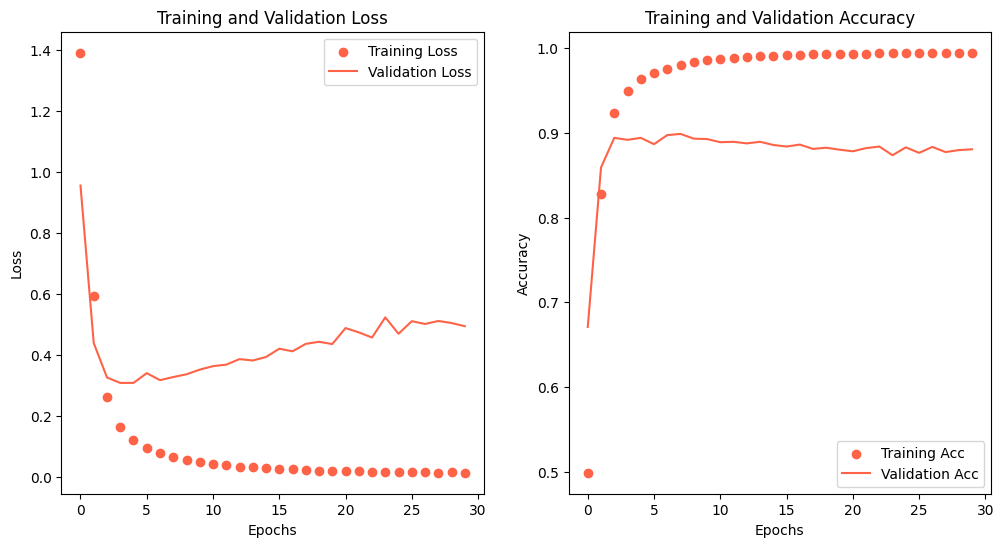

In [41]:
overfit_history_dict = overfit_history.history

plot_loss_acc(overfit_history_dict, "tomato").show()

## Hyperparameter Tuning

**Fixing overfittng**

The original model has an overfitting problem, resulting in suboptimal results when tested against a general dataset, since it is unable to generalise. I will attempt to counteract the overfitting, by implementing Regularisation and introducing Dropout Layers.

**Regularisation**

Below is a model implementing L2 regularisation. This method forces a model to be simpler, by containing the weight to smaller values.

In [42]:
from keras import regularizers

def build_reg_model(output_options_len=10, input_shape=(10000, )):
    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=input_shape))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(output_options_len, activation="softmax"))

    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [44]:
# Executes the model
reg_model = build_reg_model(len(target.keys()))
reg_history = execute_model(reg_model, final_batches, final_epochs)

By implementing Regularisation, the rate at which the model's performance degrade, appear to be slower than on the overfitting model. As can be seen on the graph, once the validation loss bottoms out, it stays very close to that loss value. On the other hand, the overfitting model, the validation loss becomes higher right after it reaches it's minimum. 

Unfortunately, the lowest point that validation loss reaches, appears to be higher than with the overfitting model.

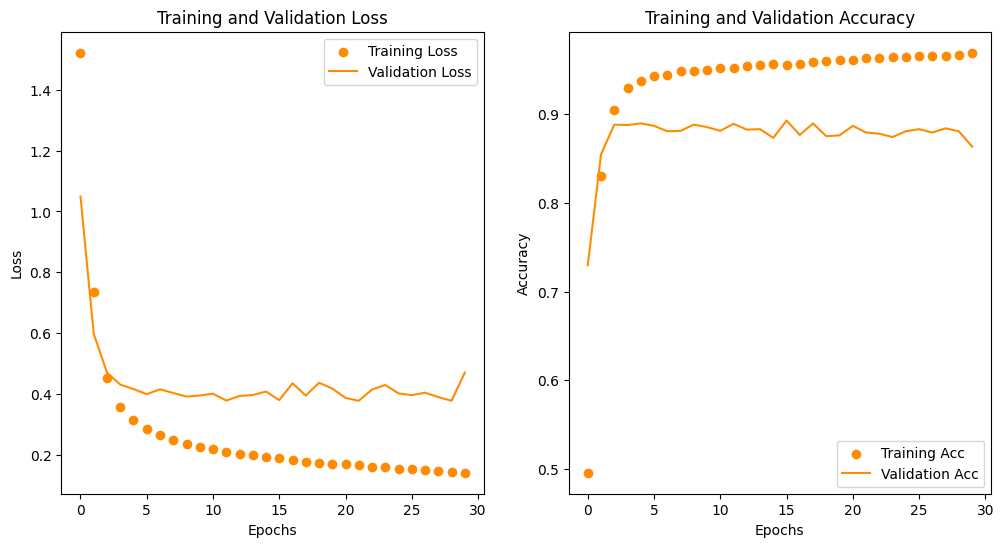

In [45]:
reg_history_dict = reg_history.history

plot_loss_acc(reg_history_dict, "darkorange").show()

**Introducing Dropout Layers**

Below is a new model, implementing two additional Dropout layers, one below each hidden layer. These layers randomly remove a subset of neurons during training, which should make the model less dependent on certain features that only exist in the training data, allowing it to generalise.

In [47]:
def build_drop_model(output_options_len=10, input_shape=(10000, )):
    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_shape=input_shape))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(output_options_len, activation="softmax"))

    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [48]:
# Execute the model
drop_model = build_drop_model(len(target.keys()))
drop_history = execute_model(drop_model, final_batches, final_epochs)

When looking at the graph for Dropout layers, the model shows two improvements over the overfitting model. Like the Regularised model, the performance degrades slower per epoch trained. It is not quite as flat as the Regularised model, but the slope at which loss increases is less  than the overfitting model.

On top of this it appears that the lowest point of validation loss is lower than the overfitting model. 

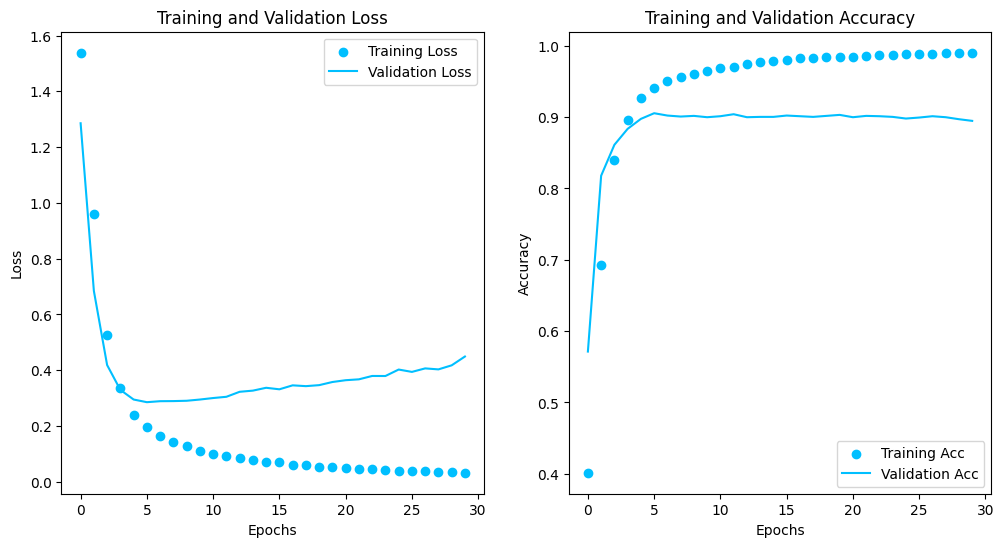

In [49]:
drop_history_dict = drop_history.history

plot_loss_acc(drop_history_dict, "deepskyblue").show()

**Combination**

Below is a model that implements both Dropout Layers and L2 Regularisation. On their own, each method did seem to make a difference, so I combined them with the same set of parameters.

In [68]:
def build_reg_drop_model(output_options_len=10, input_shape=(10000, )):
    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=input_shape))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(output_options_len, activation="softmax"))

    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [69]:
# Execute the model
reg_drop_model = build_reg_drop_model(len(target.keys()))
reg_drop_history = execute_model(reg_drop_model, final_batches, final_epochs)

When using a combination of the two previous models, the presence of the L2 Regularisation is immediately visible, indicated by the completely flat validation loss after it bottoms out. It appears that introducing the Dropout Layers did lower the minimum value of validation loss, however it is not as low as just using Dropout Layers.

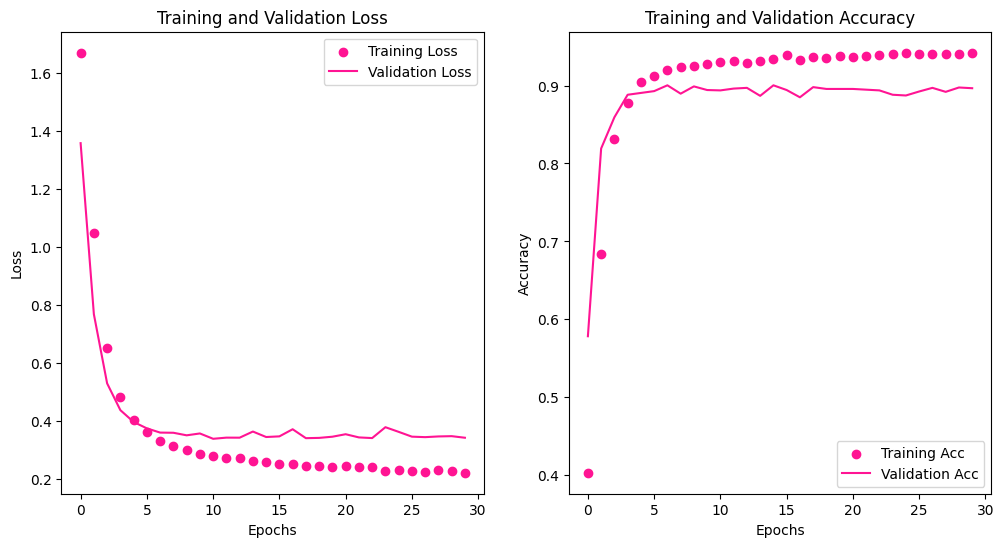

In [70]:
reg_drop_history_dict = reg_drop_history.history

plot_loss_acc(reg_drop_history_dict, "deeppink").show()

**Comparing models**

Here all of the models that have been made up until now is compared. As can be seen by the charts below, after trying multiple models, I was able to create a new model capable of somewhat fixing the overfitting problem. The Regularised and combination of Regularised and Dropout layer models, were unable to improve the overfitting problem. 

Introducing just Dropout Layers to the model, was able to improve the overfitting. As is demonstrated by the graph, the model with Dropout Layers starts overfitting layer on, from 7 epochs onwards, and the performance also degrades slower. The previous two models was able to degrade even slower, appearing to be nearly flat after 6 epochs, but their validation loss never goes down ass low as just using Drop Layers 

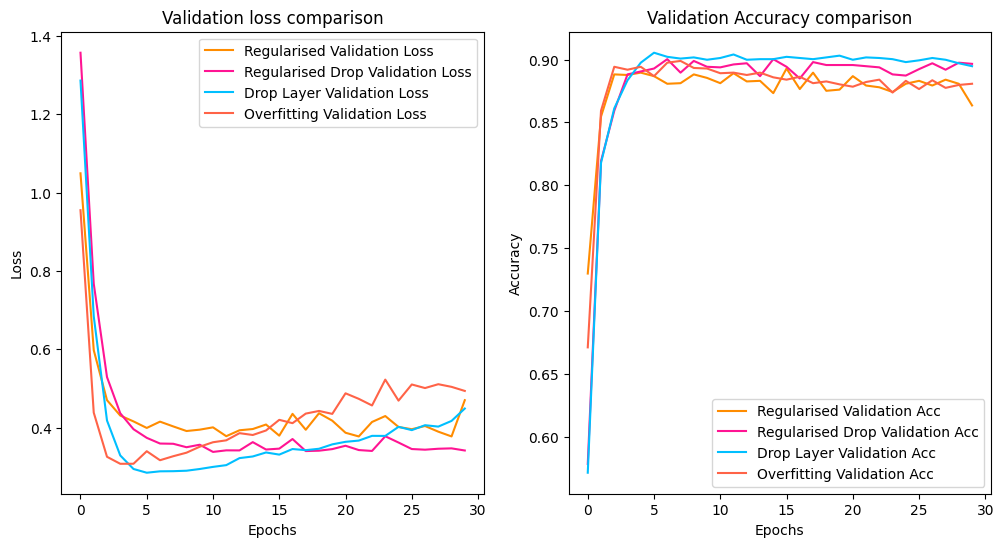

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(reg_history_dict["val_loss"], label="Regularised Validation Loss", color="darkorange")
plt.plot(reg_drop_history_dict["val_loss"], label="Regularised Drop Validation Loss", color="deeppink")
plt.plot(drop_history_dict["val_loss"], label="Drop Layer Validation Loss", color="deepskyblue")
plt.plot(overfit_history_dict["val_loss"], label="Overfitting Validation Loss", color="tomato")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation loss comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(reg_history_dict["val_accuracy"], label="Regularised Validation Acc", color="darkorange")
plt.plot(reg_drop_history_dict["val_accuracy"], label="Regularised Drop Validation Acc", color="deeppink")
plt.plot(drop_history_dict["val_accuracy"], label="Drop Layer Validation Acc", color="deepskyblue")
plt.plot(overfit_history_dict["val_accuracy"], label="Overfitting Validation Acc", color="tomato")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy comparison")
plt.legend()

plt.show()

## Testing

**Final Design**


The final design that was settled upon is identical to the Dropout Layer model from earlier. Below is some code to identify the optimal number of epochs to train the model for. It identifies when the validation loss is the lowest during the previous training, and assumed that to be the optimal number of epochs to train a new model for.

In [55]:
# Below code adapted from course material
# ---------------------------------
best_epochs = np.argmin(drop_history_dict["val_loss"])
print(best_epochs, "epochs")

5 epochs


**The final design of the model**

In [107]:
final_model = build_drop_model(len(target.keys()))
final_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 128)               1280128   
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1288774 (4.92 MB)
Trainable params: 1288774 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Below the model is once again trained, but unlike earlier, it is only trained for the the optimal number of epochs, as calculated earlier.

In [59]:
_ = execute_model(final_model, final_batches, best_epochs)

Finally the model can be evaluated with the test data, that has not been used up until now. There is a built in method to retrieve the loss and accuracy of the model, so there is little that I need to do

In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy = final_model.evaluate(x_test_arr, y_test_one_hot, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 89.19%


As was previously seen, there are is a total of 6 different possible sentiments in this data set. Picking a label at random would result in a 16.67% (1/6) chance of being correct. Using the baseline method above, there is a 33.97% chance of it being correct. This means that the "educated guess" method is double as accurate.

Regardless after training the model was abel to achieve an accuracy of 89.19% accuracy, beating the baseline by a landslide.

Below is a helper function to convert the encoded labels back to human readable text, it will be used to see the model in action.

In [62]:
# Convert convert one hot encoded value to number and select
# corisponding label string from target
def one_hot_label_to_text(encoded):
    inverted = {v: k for k, v in target.items()}
    num_labels = np.argmax(encoded, axis=1)
    return [inverted[class_num] for class_num in num_labels]

Show some of the predictions made by the model

In [64]:
predictions = final_model.predict(x_test_arr, verbose=0)

predicted_labels = one_hot_label_to_text(predictions)
actual_labels = one_hot_label_to_text(y_test_one_hot)

print("Index\tActual     \tPredicted\n" + "-" * 35)
for i in range(25):
    # marks any errors in red
    print(i, actual_labels[i] + " " * 5,  f"\033[1;31m{predicted_labels[i]}\033[0m" if actual_labels[i] != predicted_labels[i] else predicted_labels[i], sep="\t")


Index	Actual     	Predicted
-----------------------------------
0	happy     	happy
1	happy     	happy
2	anger     	anger
3	surprise     	surprise
4	happy     	happy
5	sadness     	sadness
6	happy     	happy
7	happy     	happy
8	fear     	fear
9	happy     	happy
10	happy     	fear
11	fear     	fear
12	love     	love
13	sadness     	sadness
14	love     	love
15	sadness     	sadness
16	fear     	fear
17	sadness     	sadness
18	sadness     	sadness
19	sadness     	sadness
20	happy     	happy
21	happy     	happy
22	fear     	fear
23	happy     	happy
24	happy     	anger
